In [1]:
#DB
import os
import psycopg2

# Helpers
import numpy as np
import qgrid
from tqdm import tqdm_notebook
import time
import pandas as pd

# Evaluation
from gap import define_k

# Plots
import matplotlib.pyplot as plt

## Connect to DB

In [2]:
connection = psycopg2.connect(user = "machineteaching",
                                  password = "vw_$Z^vBgn?7H{z4",
                                  host = "localhost",
#                                   port = "5432",
                                  database = "machineteaching")
connection.autocommit=True
cursor = connection.cursor()

In [4]:
%%time

vectorizers = [
    'CountVectorizer',
    'TfidfVectorizer', 
    'NCutVectorizer'
]
min_df = np.arange(0.05, 0.51, 0.05)
binary = [
    True, 
    False
]
cluster_methods = [
    'nmf',
    'lda'
]
#, 'hierarchical', 'gaussian_mixture', 'spectral_clustering']
metric = [
    'euclidean', 
#     'cosine',
#     'correlation'
]

total = 0
total_rows = 0

# Grid search
for v in tqdm_notebook(vectorizers, desc="vectorizer", leave=False):
    for m in tqdm_notebook(min_df, desc="min_df", leave=False):
        for b in tqdm_notebook(binary, desc="binary", leave=False):
            for dist in tqdm_notebook(metric, desc="metric", leave=False):
                for method in tqdm_notebook(cluster_methods, desc="method", leave=False):
#                         total += 1
                    # Get results for each combination and get best k value
                    cols = ["experiment_id", "dataset", "k", "gap", "gap_std", "silhouette", "silhouette_samples", 
                            "coherence_samples5", "coherence_med5", "coherence_std5", "coherence_k5",
                            "coherence_samples10", "coherence_med10", "coherence_std10", "coherence_k10",
                            "coherence_samples15", "coherence_med15", "coherence_std15", "coherence_k15"]
#                         cols = ['dataset', 'k', 'min_df', 'is_binary', 'vectorizer', 'method', 'distance', 'gap', 'clustering_time', 'gap_time', 'silhouette_time', 'coherence_time']

                    query = "SELECT %s from experiments_solution where " % ", ".join(cols)
                    where_clause = [("vectorizer", v), ("min_df", m), ("is_binary", b), 
                                    ("distance", dist), ("method", method), ("dataset", 'solution_all')]
                    query += " AND ".join(["%s = '%s'" % item for item in where_clause])
#                         print(query)
                    cursor.execute(query)
                    r = cursor.fetchall()
                    df = pd.DataFrame(r, columns=cols)
                    total += df.shape[0]
                    total_rows += 1

                    if df.shape[0]:
                        experiment_id = df['experiment_id'].values.tolist()[0]

                        # Get measure values
                        gaps_original = df['gap'].values.tolist()
                        gaps = gaps_original[:]
                        error = df['gap_std'].values.tolist()
                        sils = df['silhouette'].values.tolist()
                        coherence5 = df['coherence_med5'].values.tolist()
                        coherence_std5 = df['coherence_std5'].values.tolist()
                        coherence_array5 = df['coherence_samples5'].values.tolist()
                        coherence10 = df['coherence_med10'].values.tolist()
                        coherence_std10 = df['coherence_std10'].values.tolist()
                        coherence_array10 = df['coherence_samples10'].values.tolist()
                        coherence15 = df['coherence_med15'].values.tolist()
                        coherence_std15 = df['coherence_std15'].values.tolist()
                        coherence_array15 = df['coherence_samples15'].values.tolist()

                        # Gap
                        gap_k, gap_k2 = define_k(gaps, error)
                        # Silhouette
                        silhouette_k = np.argsort(np.asarray(sils))[::-1][0]+2
                        try:
                            silhouette_k2 = np.argsort(np.asarray(sils))[::-1][1]+2
                        except IndexError:
                            silhouette_k2 = 0
                        # Coherence
#                         coherence_med = []
#                         coherence_std = []
#                         for c in coherence_array:
#                             coherence_med.append(np.median(np.asarray([i for i in c if str(i) != 'nan'])))
#                             coherence_std.append(np.std(np.asarray([i for i in c if str(i) != 'nan'])))
                        coherence_k5 = np.argsort(np.asarray(coherence5))[::-1][0]+2
                        coherence_k10 = np.argsort(np.asarray(coherence10))[::-1][0]+2
                        coherence_k15 = np.argsort(np.asarray(coherence15))[::-1][0]+2
                        try:
                            coherence_k2_5 = np.argsort(np.asarray(coherence5))[::-1][1]+2
                            coherence_k2_10 = np.argsort(np.asarray(coherence10))[::-1][1]+2
                            coherence_k2_15 = np.argsort(np.asarray(coherence15))[::-1][1]+2
                        except IndexError:
                            coherence_k2_5 = 0
                            coherence_k2_10 = 0
                            coherence_k2_15 = 0

                        cols = ["experiment_id", "gap_k", "gap_k2", "silhouette_k", "silhouette_k2", 
                                "coherence_k5", "coherence_k2_5", "coherence_k10", "coherence_k2_10", 
                                "coherence_k15", "coherence_k2_15"]
                        insert_query = "INSERT INTO EXPERIMENTS_SOLUTION_RESULT (%s) VALUES " % ", ".join(cols)
                        values = [experiment_id, gap_k, gap_k2, silhouette_k, silhouette_k2, 
                                  coherence_k5, coherence_k2_5, coherence_k10, coherence_k2_10, 
                                  coherence_k15, coherence_k2_15]
                        values = [int(i) for i in values]
                        insert_query += "(" + ", ".join(["%s"]*len(values)) + ")"
                        query = cursor.mogrify(insert_query, values)
                        try:
                            r = cursor.execute(query)
                        except psycopg2.IntegrityError:
#                             print("error on exp id %d" % experiment_id)
                            pass

/home/lmoraes/machine-teaching/machineteaching/gap.py:97: RuntimeWarning: invalid value encountered in greater
  gap_diff = np.array(gaps) > diff


CPU times: user 3.15 s, sys: 108 ms, total: 3.26 s
Wall time: 37.7 s


In [5]:
total

1627

In [6]:
total_rows

120

In [104]:
# Get experiment conditions
# exp_id = 823
# exp_id = 828
# exp_id = 936
exp_id = 1463
# exp_id = 26
# exp_id = 409
# exp_id = 349
# exp_id = 24

cols = ["vectorizer", "min_df", "is_binary", "distance", "method", "dataset"]
query = "SELECT %s from experiments_solution where experiment_id = %s" % (", ".join(cols), exp_id) 
cursor.execute(query)
where_items = cursor.fetchall()
# print(r[0])

where_clause = zip(*[cols, where_items[0]])

# Get all k
cols = ["experiment_id", "dataset", "k", "gap", "gap_std", "silhouette", "silhouette_samples", 
        "coherence_samples5", "coherence_med5", "coherence_std5", "coherence_k5", 
        "coherence_samples10", "coherence_med10", "coherence_std10", "coherence_k10",
        "coherence_samples15", "coherence_med15", "coherence_std15", "coherence_k15","model"]

query = "SELECT %s from experiments_solution where " % ", ".join(cols)
query += " AND ".join(["%s = '%s'" % item for item in where_clause])
cursor.execute(query)
print(query)
r = cursor.fetchall()
df = pd.DataFrame(r, columns=cols)

# Get measure values
gaps_original = df['gap'].values.tolist()
gaps = gaps_original[:]
error = df['gap_std'].values.tolist()
sils = df['silhouette'].values.tolist()
coherence5 = df['coherence_med5'].values.tolist()
coherence_std5 = df['coherence_std5'].values.tolist()
coherence_array5 = df['coherence_samples5'].values.tolist()
coherence10 = df['coherence_med10'].values.tolist()
coherence_std10 = df['coherence_std10'].values.tolist()
coherence_array10 = df['coherence_samples10'].values.tolist()
coherence15 = df['coherence_med15'].values.tolist()
coherence_std15 = df['coherence_std15'].values.tolist()
coherence_array15 = df['coherence_samples15'].values.tolist()

# Gap
gap_k, gap_k2 = define_k(gaps, error)
# Silhouette
silhouette_k = np.argsort(np.asarray(sils))[::-1][0]+2
try:
    silhouette_k2 = np.argsort(np.asarray(sils))[::-1][1]+2
except IndexError:
    silhouette_k2 = 0
# Coherence
coherence_k5 = np.argsort(np.asarray(coherence5))[::-1][0]+2
coherence_k10 = np.argsort(np.asarray(coherence10))[::-1][0]+2
coherence_k15 = np.argsort(np.asarray(coherence15))[::-1][0]+2
try:
    coherence_k2_5 = np.argsort(np.asarray(coherence5))[::-1][1]+2
    coherence_k2_10 = np.argsort(np.asarray(coherence10))[::-1][1]+2
    coherence_k2_15 = np.argsort(np.asarray(coherence15))[::-1][1]+2
except IndexError:
    coherence_k2_5 = 0
    coherence_k2_10 = 0
    coherence_k2_15 = 0

SELECT experiment_id, dataset, k, gap, gap_std, silhouette, silhouette_samples, coherence_samples5, coherence_med5, coherence_std5, coherence_k5, coherence_samples10, coherence_med10, coherence_std10, coherence_k10, coherence_samples15, coherence_med15, coherence_std15, coherence_k15, model from experiments_solution where vectorizer = 'NCutVectorizer' AND min_df = '0.35' AND is_binary = 'True' AND distance = 'euclidean' AND method = 'nmf' AND dataset = 'solution_all'


/home/lmoraes/Documents/machine-teaching/machineteaching/gap.py:97: RuntimeWarning: invalid value encountered in greater
  gap_diff = np.array(gaps) > diff


In [105]:
df.sort_values('k')

,experiment_id,dataset,k,gap,gap_std,silhouette,silhouette_samples,coherence_samples5,coherence_med5,coherence_std5,coherence_k5,coherence_samples10,coherence_med10,coherence_std10,coherence_k10,coherence_samples15,coherence_med15,coherence_std15,coherence_k15,model
0,1451,solution_all,2,-0.433430,0.011205,0.208500,"[0.297362, 0.286933, 0.216973, 0.261044, 0.201...","[-0.247591, -0.0431489]",-0.145370,0.102221,2,"[-0.167628, -0.106119]",-0.136874,0.030755,2,"[-0.220708, -0.114442]",-0.167575,0.053133,2,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
1,1454,solution_all,3,-0.444908,0.016149,0.118506,"[0.259204, 0.185115, 0.2041, 0.266484, 0.22372...","[-0.148935, -0.0431489, 0.00332779]",-0.043149,0.063714,3,"[-0.115239, -0.0210656, -0.120982]",-0.115239,0.045807,3,"[-0.220135, -0.149164, -0.139493]",-0.149164,0.035953,3,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
2,1456,solution_all,4,NaN,0.013870,0.148188,"[0.30437, 0.230142, 0.159026, 0.260199, 0.1952...","[0.00166528, 0.000624805, -0.0125869]",0.000625,0.006487,3,"[-0.126729, 0.000624805, -0.151994]",-0.126729,0.066791,3,"[-0.112348, -0.16088, -0.280848]",-0.160880,0.070820,3,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
3,1459,solution_all,5,NaN,0.026064,0.085100,"[0.283563, 0.122806, 0.141816, 0.235655, 0.156...","[0.00332779, -0.0244132, -0.00644244, -0.0547072]",-0.015428,0.022084,4,"[0.00332779, -0.0119126, -0.14635, -0.0261051]",-0.019009,0.059285,4,"[-0.0234819, -0.167517, -0.791728, -0.332749]",-0.250133,0.288769,4,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
4,1460,solution_all,6,NaN,NaN,0.038205,"[0.299738, 0.101506, 0.0200502, 0.22146, 0.185...","[0.00332779, -0.0338044, 0.00332779, -0.007757...",-0.002215,0.044126,6,"[0.00332779, -0.0166391, -0.0903955, -0.113385...",-0.042383,0.047306,6,"[-0.0234819, -0.119655, -0.478017, -0.874346, ...",-0.448271,0.291411,6,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
5,1463,solution_all,7,NaN,0.014197,-0.046570,"[-0.16889, -0.000680167, 0.0252352, 0.11427, 0...","[0.00995033, 0.000476077, 0.00995033, 0.000370...",0.006639,0.004388,6,"[0.00995033, 0.000476077, 0.00995033, -0.18594...",0.006639,0.071901,6,"[0.00995033, -0.114625, 0.00995033, -0.362809,...",-0.110839,0.235400,6,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
6,1466,solution_all,8,NaN,NaN,0.067127,"[0.26746, 0.103761, 0.205947, 0.29909, 0.24131...","[-0.00884091, 0.000322529, 0.00995033]",0.000323,0.007672,3,"[-0.00419323, -0.166908, 0.00995033]",-0.004193,0.080246,3,"[-0.139957, -0.308539, -0.319701]",-0.308539,0.082227,3,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
7,1469,solution_all,9,NaN,NaN,0.133249,"[0.271496, 0.113833, 0.203784, 0.336071, 0.276...","[-0.00884091, 0.000357079, 0.00249688]",0.000357,0.004919,3,"[-0.00419323, -0.936418, -0.0483327]",-0.048333,0.429429,3,"[-0.12553, -0.825787, -0.469371]",-0.469371,0.285894,3,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
8,1470,solution_all,10,NaN,NaN,0.054895,"[0.0934405, 0.0203562, 0.19863, 0.27795, 0.244...","[0.00498754, 0.000476077, 0.00249688, 0.000399...",0.002497,0.002037,5,"[-1.22069, 0.000476077, -0.697755, -0.19868, 0...",-0.198680,0.474264,5,"[-1.16379, -0.183456, -0.383345, -0.433329, -0...",-0.415599,0.336075,5,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."
9,1472,solution_all,11,NaN,NaN,0.217422,"[0.307414, 0.277762, 0.209894, 0.287317, 0.230...","[0.000454442, 0.000312451]",0.000383,0.000071,2,"[-0.0253017, -0.157983]",-0.091642,0.066340,2,"[-0.145168, -0.297497]",-0.221332,0.076164,2,"[b'g', b'A', b'N', b'j', b'c', b'2', b't', b's..."


In [90]:
%matplotlib notebook

<IPython.core.display.Javascript object>


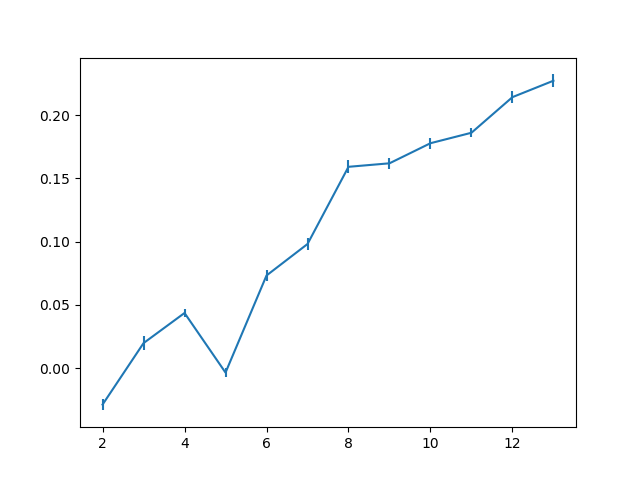

k = 4
2nd k = 8


In [91]:
# Plot data
plt.figure()
plt.errorbar(range(2,len(gaps)+2), gaps_original, yerr=error)
plt.show()

# Get best k
print("k = %d" % gap_k)
print("2nd k = %d" % gap_k2)

<IPython.core.display.Javascript object>


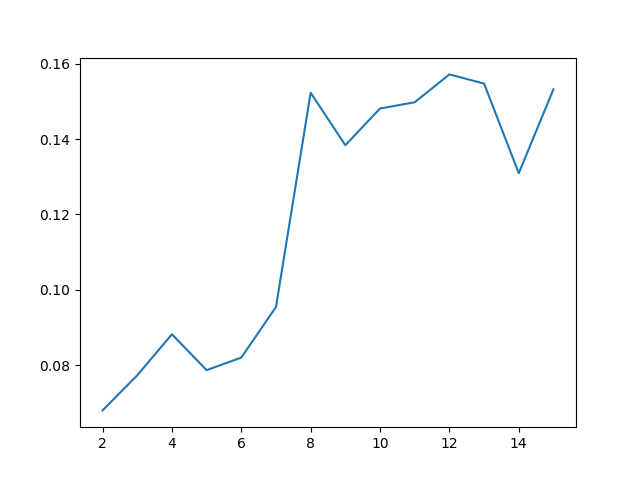

k = 12
2nd k = 13


In [92]:
# Plot data
plt.figure()
plt.plot(range(2,len(sils)+2), sils)
plt.show()

# Get best k
print("k = %d" % silhouette_k)
print("2nd k = %d" % silhouette_k2)

<IPython.core.display.Javascript object>


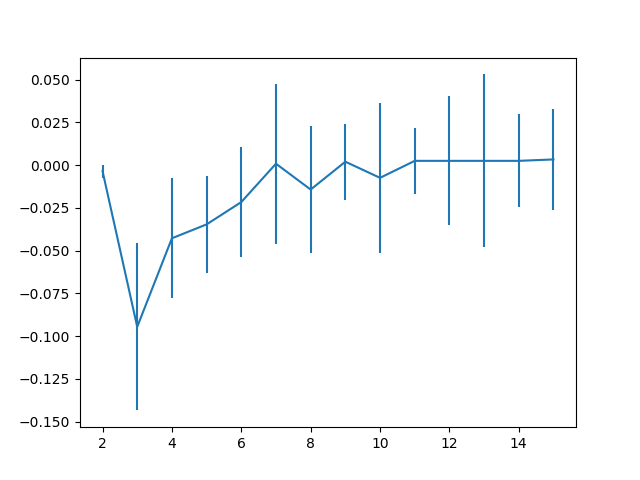

k = 15
2nd k = 14
CPU times: user 114 ms, sys: 8.15 ms, total: 122 ms
Wall time: 143 ms


In [93]:
%%time

# Plot data
plt.figure()
plt.errorbar(range(2,len(coherence5)+2), coherence5, yerr=coherence_std5)
plt.show()

# Get best k
# Get best k
print("k = %d" % coherence_k5)
print("2nd k = %d" % coherence_k2_5)

<IPython.core.display.Javascript object>


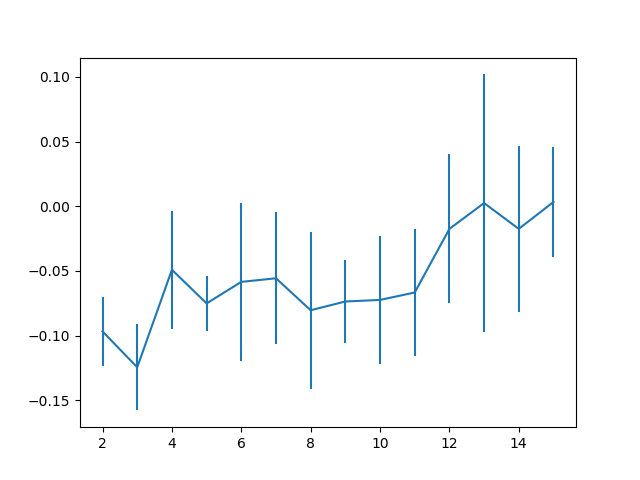

k = 15
2nd k = 13
CPU times: user 113 ms, sys: 4.03 ms, total: 117 ms
Wall time: 150 ms


In [94]:
%%time

# Plot data
plt.figure()
plt.errorbar(range(2,len(coherence10)+2), coherence10, yerr=coherence_std10)
plt.show()

# Get best k
# Get best k
print("k = %d" % coherence_k10)
print("2nd k = %d" % coherence_k2_10)

<IPython.core.display.Javascript object>


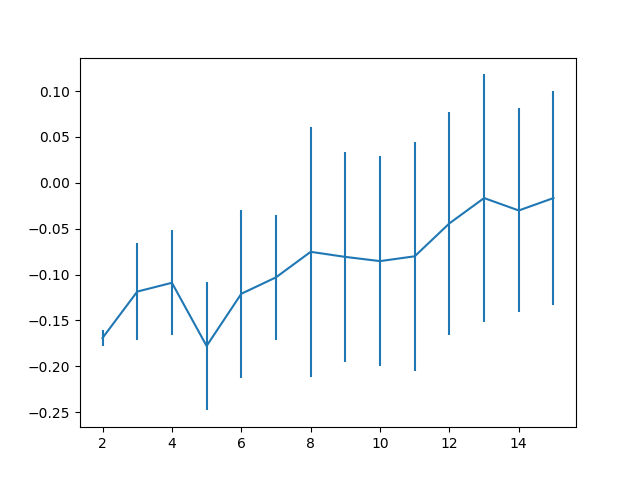

k = 15
2nd k = 13
CPU times: user 129 ms, sys: 3.95 ms, total: 133 ms
Wall time: 169 ms


In [95]:
%%time

# Plot data
plt.figure()
plt.errorbar(range(2,len(coherence15)+2), coherence15, yerr=coherence_std15)
plt.show()

# Get best k
# Get best k
print("k = %d" % coherence_k15)
print("2nd k = %d" % coherence_k2_15)

<IPython.core.display.Javascript object>


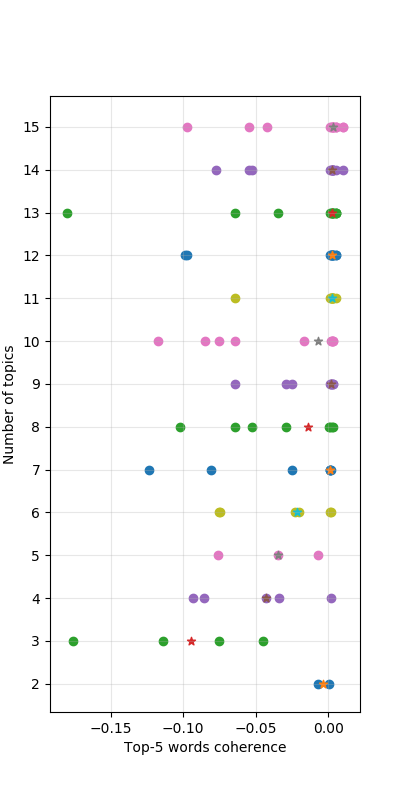

<IPython.core.display.Javascript object>


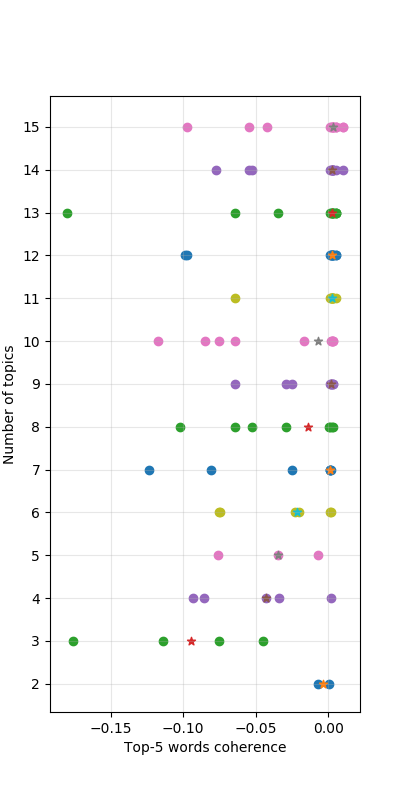

In [70]:
plt.figure(figsize=(4,8))
for idx, i in enumerate(coherence_array5):
    median = np.median([item for item in i if str(item) != 'nan'])
#     val = [item for item in i if item > -0.05]
#     plt.scatter(val, [idx+2]*len(val))
    plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")
    
plt.yticks(range(2,len(coherence_array5)+2), range(2,len(coherence_array5)+2))
plt.ylabel("Number of topics")
plt.xlabel("Top-5 words coherence")
plt.grid(alpha=0.3)


plt.figure(figsize=(4,8))
for idx, i in enumerate(coherence_array5):
    median = np.median([item for item in i if str(item) != 'nan'])
    val = [item for item in i if item > -1]
    plt.scatter(val, [idx+2]*len(val))
#     plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")
    
plt.yticks(range(2,len(coherence_array5)+2), range(2,len(coherence_array5)+2))
plt.ylabel("Number of topics")
plt.xlabel("Top-5 words coherence")
plt.grid(alpha=0.3)

<IPython.core.display.Javascript object>


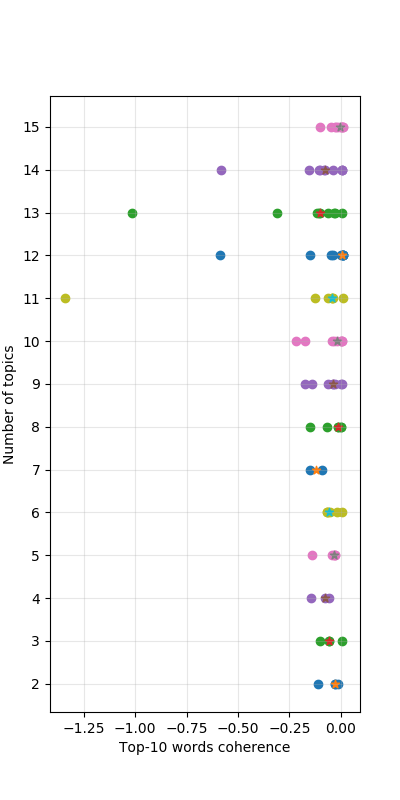

In [13]:
plt.figure(figsize=(4,8))
for idx, i in enumerate(coherence_array10):
    median = np.median([item for item in i if str(item) != 'nan'])
    plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")
    
plt.yticks(range(2,len(coherence_array10)+2), range(2,len(coherence_array10)+2))
plt.ylabel("Number of topics")
plt.xlabel("Top-10 words coherence")
plt.grid(alpha=0.3)

<IPython.core.display.Javascript object>


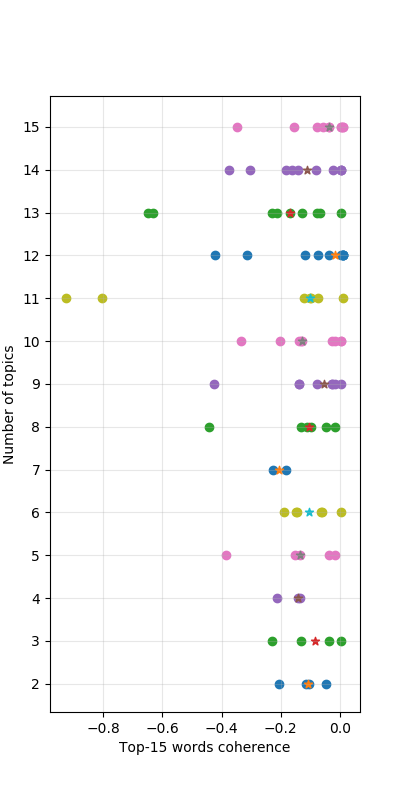

In [14]:
plt.figure(figsize=(4,8))
for idx, i in enumerate(coherence_array15):
    median = np.median([item for item in i if str(item) != 'nan'])
    plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")
    
plt.yticks(range(2,len(coherence_array15)+2), range(2,len(coherence_array15)+2))
plt.ylabel("Number of topics")
plt.xlabel("Top-15 words coherence")
plt.grid(alpha=0.3)

In [106]:
import pickle
import base64
from clustering import Clustering
from analyzer import python_analyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from vectorizer import NCutVectorizer

In [107]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=last_id)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be ignored: 591
Problems to be used: 132
Solutions to be used: 54
Got 54 documents


In [113]:
query = "select model, X from experiments_solution where experiment_id = %s" % exp_id
cursor.execute(query)
r = cursor.fetchall()

In [114]:
r

[(<memory at 0x7f1203d0eb88>,
  [[0.136054,
    0.0,
    0.0,
    0.0,
    0.0,
    0.136054,
    0.136054,
    0.0,
    0.0,
    0.136054,
    0.0,
    0.0,
    0.136054,
    0.0,
    0.188905,
    0.158068,
    0.0,
    0.0,
    0.160081,
    0.196029,
    0.0,
    0.0,
    0.136054],
   [0.136054,
    0.0,
    0.0,
    0.0,
    0.0,
    0.136054,
    0.136054,
    0.0,
    0.218098,
    0.136054,
    0.0,
    0.0,
    0.136054,
    0.0,
    0.188905,
    0.158068,
    0.0,
    0.0,
    0.160081,
    0.196029,
    0.0,
    0.199908,
    0.136054],
   [0.136054,
    0.0,
    0.174017,
    0.0,
    0.160081,
    0.136054,
    0.136054,
    0.213089,
    0.0,
    0.136054,
    0.182504,
    0.185622,
    0.136054,
    0.213089,
    0.0,
    0.158068,
    0.0,
    0.0,
    0.0,
    0.0,
    0.192368,
    0.0,
    0.136054],
   [0.136054,
    0.0,
    0.0,
    0.0,
    0.0,
    0.136054,
    0.136054,
    0.0,
    0.0,
    0.136054,
    0.0,
    0.0,
    0.136054,
    0.0,
    0.0,
    0.

In [109]:
model_db = pickle.loads(base64.b64decode(r[0][0]))
model_db

/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator NMF from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=7, random_state=4049318698, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [110]:
X = np.asarray(r[0][1])
X.shape

(54, 23)

In [111]:
import io
import tokenize
def test_integrity(doc):
    file = io.StringIO(doc)
    try:
        for token in tokenize.generate_tokens(file.readline):
            continue
    except Exception:
        return False
    return True
        
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
    for idx, d in enumerate(docs):
        if not test_integrity(d):
            print("error on %d" % idx)
    vectorizer = vectorizer_method(analyzer = python_analyzer,
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features, vectorizer.get_feature_names()

In [112]:
where_items

[('NCutVectorizer', 0.35, True, 'euclidean', 'nmf', 'solution_all')]

In [51]:
# %load vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from analyzer import python_analyzer
import numpy as np


class NCutVectorizer(object):
    def __init__(self, analyzer, binary, min_df):
        self.vectorizer = CountVectorizer(analyzer = python_analyzer,
                                          binary=binary,
                                          min_df=min_df)

    def fit_transform(self, docs):
        train_data_features = self.vectorizer.fit_transform(docs)
        train_data_features = train_data_features.toarray()

        # Calculate NCut-weight
        doc_mat_norm = normalize(train_data_features)
        S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001
        D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])
        Y = np.dot(D, train_data_features.T)
        return Y.T
    
    def get_feature_names(self):
        return self.vectorizer.get_feature_names()


In [53]:
v = eval(where_items[0][0])
m = where_items[0][1]
b = where_items[0][2]
dist = where_items[0][3]
method = where_items[0][4]
k = 8

train_data_features, feature_names = create_bag_of_words(solutions, v, binary=b, min_df=m)
clustering = Clustering(train_data_features, k, metric=dist)
clustering.seed = base

In [54]:
model, document_topic, word_topic = getattr(clustering, method)()
print("Count per class:")
clusters = clustering.document_topic.argmax(axis=1)
counts = np.unique(clusters, return_counts=True)
counts
# for i in range(clustering.k):
#     print("Topic %d: %d" % ((i+1), counts[1][i]))

Count per class:


(array([1, 2, 4, 6, 7]), array([ 4, 24, 14,  7,  5]))

In [55]:
word_topic.shape

(22, 8)

In [56]:
model_db.components_.shape

(8, 22)

In [57]:
def print_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        names = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(names)
        message += ", ".join(names)
        print(message)
    print()
    return top_words

In [58]:
print("\nTopics in NMF model (Frobenius norm):")
# print(len(feature_names))
top_words = print_top_words(model, feature_names, 5)


Topics in NMF model (Frobenius norm):
Topic #0: return, is_indent, is_block, is_block is_indent, is_dedent
Topic #1: is_dedent return, is_op_arit, in, is_attribution, is_indent
Topic #2: def, is_dedent, is_block is_indent, return, is_indent
Topic #3: return, is_indent, is_block, is_block is_indent, is_dedent
Topic #4: is_number is_block is_indent, is_number is_block, if, is_number, is_block
Topic #5: is_dedent return, is_op_logic, is_number, is_attribution, if
Topic #6: is_block is_indent if, is_indent if, is_dedent is_dedent, if, is_block
Topic #7: is_op_logic, is_block is_indent if, is_indent if, is_dedent is_dedent, if



In [59]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=0)
    matrix_norm = matrix / row_sums[np.newaxis, :]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

In [60]:
# word_topic_norm = normalize_per_row(word_topic)
x = ["Topic %d" % (idx+1) for idx in range(model.components_.shape[0])]
y = feature_names
# word_topic_df = pd.DataFrame(word_topic_norm, index=y, columns=x)
word_topic_df = pd.DataFrame(word_topic, index=y, columns=x)
avg_weight = np.percentile(word_topic, 75)
word_topic_df = sort_distribution(word_topic_df, x, MIN_PROB=avg_weight)
avg_weight

7.4015056223476492

In [61]:
word_topic_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
def,0.125001,4.125406,23.793572,0.125001,13.799547,0.280745,7.401506,5.349221
is_dedent,0.125001,4.125406,23.793572,0.125001,13.799547,0.280745,7.401506,5.349221
is_block is_indent,0.125001,4.125406,23.793572,0.125001,13.799547,0.280745,7.401506,5.349221
return,0.125001,4.125406,23.793572,0.125001,13.799547,0.280745,7.401506,5.349221
is_indent,0.125001,4.125406,23.793572,0.125001,13.799547,0.280745,7.401506,5.349221
is_block,0.125001,4.125406,23.793572,0.125001,13.799547,0.280745,7.401506,5.349221
is_op_arit,0.125001,4.125482,22.563929,0.125001,11.534215,0.125000,1.276371,0.125000
is_number,0.125001,4.125380,17.547208,0.125001,13.923590,0.416936,0.125076,4.611807
is_attribution,0.125001,4.125420,15.602698,0.125001,12.732818,0.392815,6.771204,0.125043
is_list,0.125001,2.125134,14.053595,0.125001,8.595369,0.125000,3.725899,0.125000


<IPython.core.display.Javascript object>


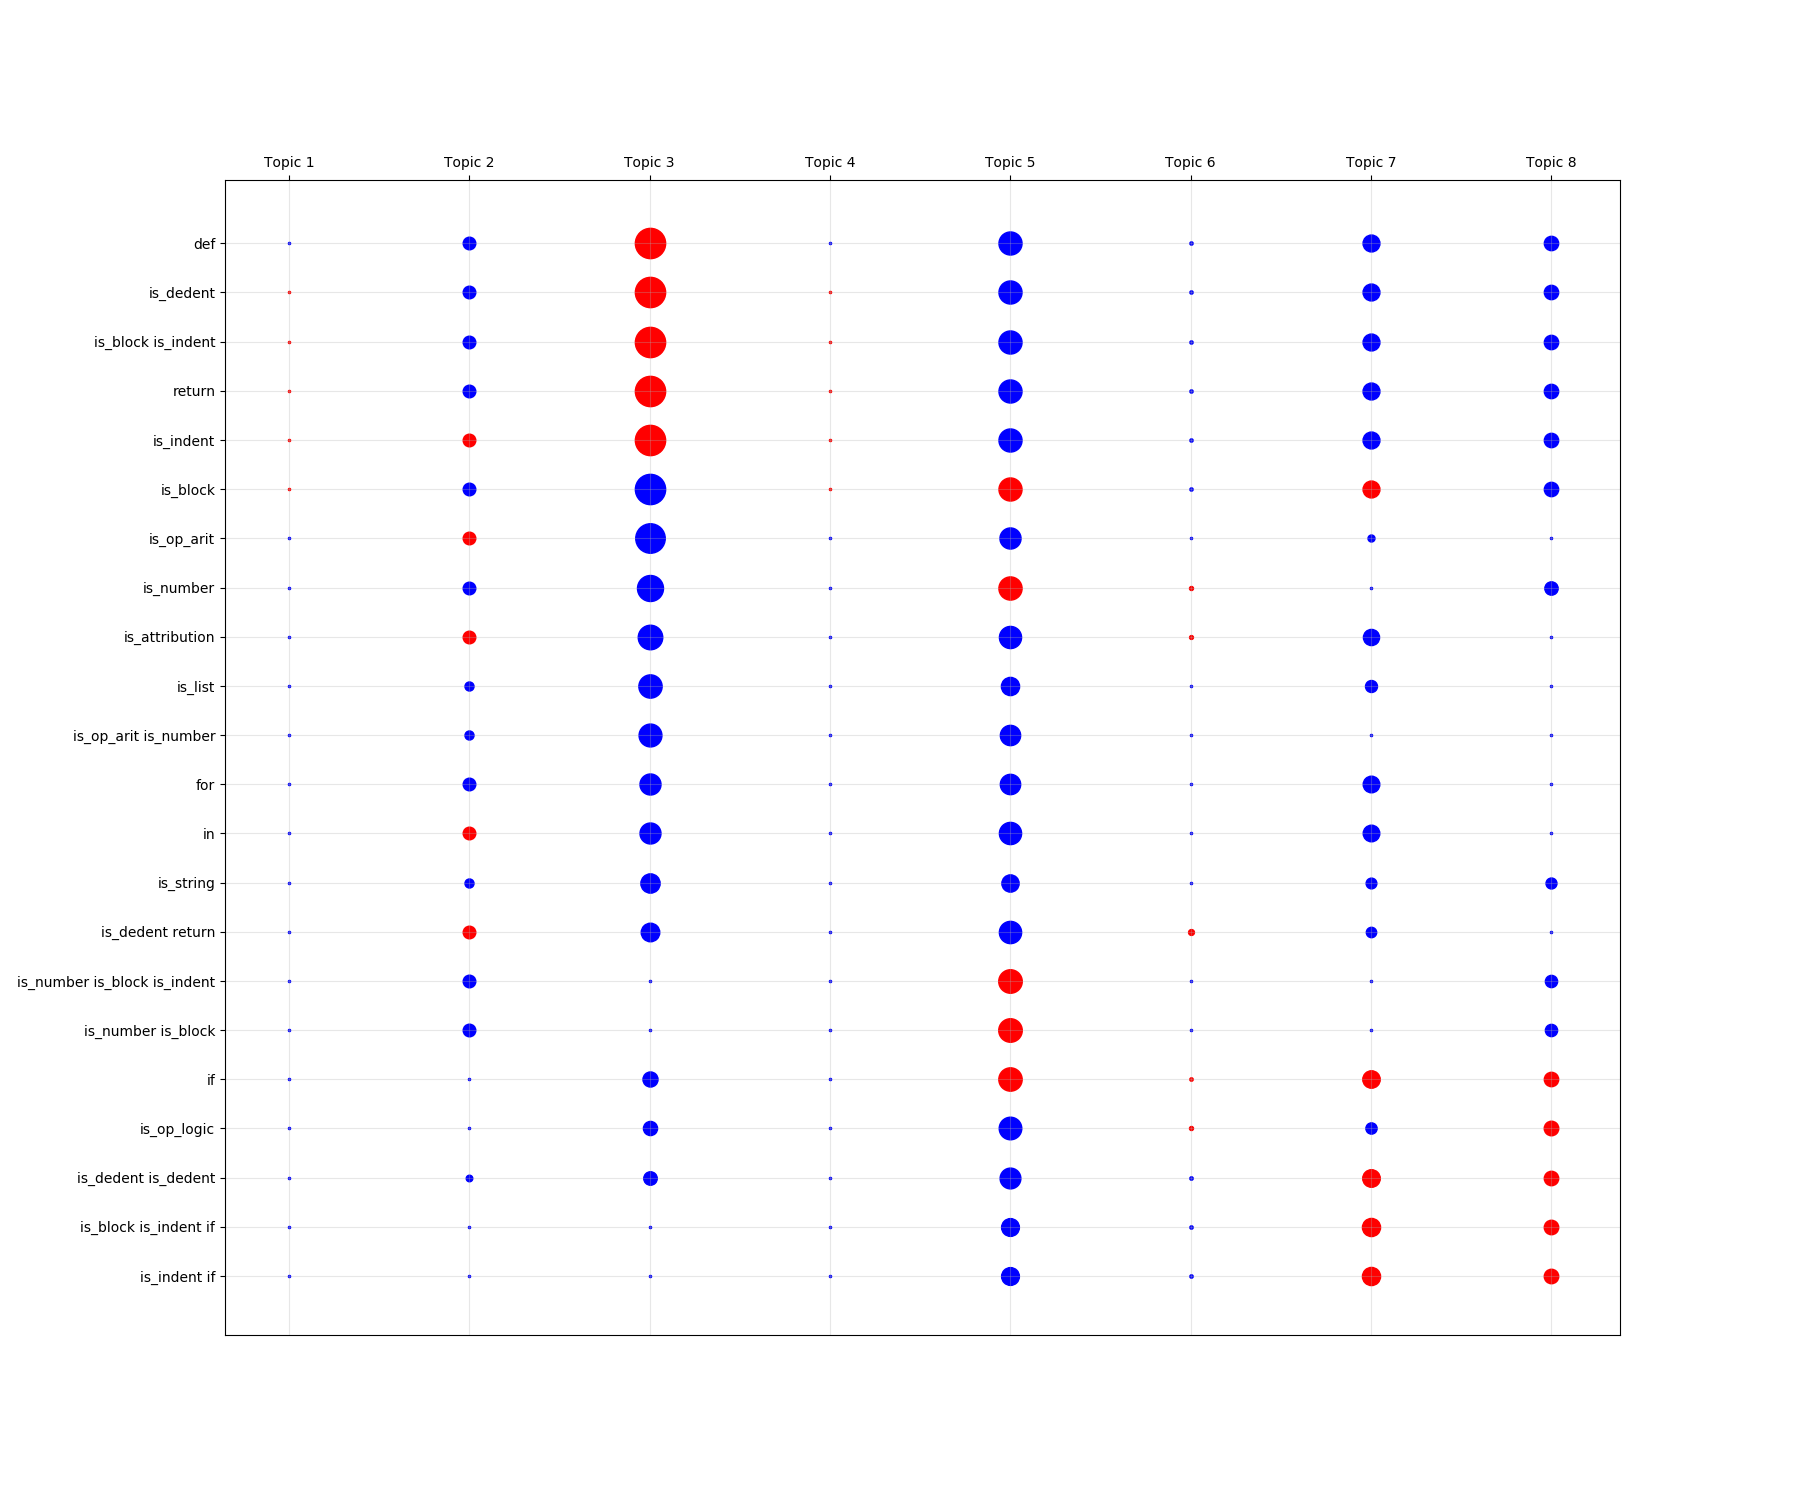

In [63]:
plt.figure(figsize=(18,15))

points = word_topic_df.values
cols = word_topic_df.columns
rows = word_topic_df.index

plt.xticks(range(0,len(cols)), cols)
plt.yticks(range(0,len(rows)), rows)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=False,
    labeltop=True)
plt.grid(alpha=0.3)

for x_item in range(len(cols)):
    for y_item in range(len(rows)):

        if rows[y_item] in top_words[x_item]:
            c = 'r'
        else:
            c = 'b'
        plt.scatter(x_item, y_item, s=points[y_item, x_item]*20, c=c)

plt.gca().invert_yaxis()
plt.show()